## Step 1: Load the Required Libraries
In this step, we import the necessary libraries, including PyTorch for building the model,
and other utilities for data preprocessing, loading, and splitting.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import random

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Step 2: Load and Preprocess the Dataset
Here, we load the dataset from the CSV files and preprocess it for training the model.


In [3]:
# Load the preprocessed data from CSV files
train_data = pd.read_csv("../train.csv")
val_data = pd.read_csv("../val.csv")
test_data = pd.read_csv("../test.csv")

X_train = train_data['text']
y_train = train_data['label']

X_val = val_data['text']
y_val = val_data['label']

X_test = test_data['text']
y_test = test_data['label']

## Step 3: Load Pre-trained Word2Vec Embeddings
We use pre-trained Word2Vec embeddings to represent words as dense vectors.
These embeddings improve the performance of the model by leveraging semantic relationships between words.

In [4]:
# Load pre-trained Word2Vec model
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

In [5]:
# Create a vocabulary
embedding_dim = 300
vocab = {"<PAD>": 0, "<UNK>": 1}  # Special tokens
embedding_matrix = [np.zeros(embedding_dim), np.random.uniform(-0.01, 0.01, embedding_dim)]  # Initialize <PAD> and <UNK>

In [6]:
# Build vocabulary from Word2Vec
for text in X_train:
    for word in text.split():
        if word not in vocab and word in word2vec:
            vocab[word] = len(vocab)
            embedding_matrix.append(word2vec[word])

embedding_matrix = np.array(embedding_matrix)
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 76131


#$ Step 4: Tokenize and Pad Sequences
Convert the text into sequences of integers based on the vocabulary. We also pad sequences to ensure they all have the same length for batch processing.

In [7]:
# Tokenize and convert text to sequences
def text_to_sequence(text, vocab, max_len=1000):
    sequence = [vocab.get(word, vocab["<UNK>"]) for word in text.split()]
    if len(sequence) < max_len:
        sequence.extend([vocab["<PAD>"]] * (max_len - len(sequence)))
    return sequence[:max_len]

# Apply tokenization
max_len = 1000
X_train_seq = [text_to_sequence(text, vocab, max_len) for text in X_train]
X_val_seq = [text_to_sequence(text, vocab, max_len) for text in X_val]
X_test_seq = [text_to_sequence(text, vocab, max_len) for text in X_test]

## Step 5: Create a Dataset and DataLoader
We define a custom Dataset class to handle our data and create DataLoader objects
to efficiently load data during training and validation.

In [8]:
def augment_text(text):
    words = text.split()
    # Randomly drop some words (with 20% probability)
    words = [w for w in words if random.random() > 0.2]
    # If we dropped all words (unlikely but possible), return original text
    if not words:
        return text
    return ' '.join(words)

# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, is_training=False):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)
        self.is_training = is_training
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        if self.is_training:
            # Get the original sequence
            sequence = self.texts[idx].tolist()  # Convert tensor to list
            # Remove padding tokens for augmentation
            sequence = [x for x in sequence if x != vocab["<PAD>"]]
            # Augment
            if len(sequence) > 0:  # Only augment if we have tokens
                sequence = [x for x in sequence if random.random() > 0.2]
            # Re-pad the sequence
            if len(sequence) < max_len:
                sequence.extend([vocab["<PAD>"]] * (max_len - len(sequence)))
            sequence = sequence[:max_len]
            # Convert back to tensor
            text = torch.tensor(sequence, dtype=torch.long)
        else:
            text = self.texts[idx]
            
        return text, self.labels[idx]

In [9]:
# Create Dataset and DataLoader
train_dataset = TextDataset(X_train_seq, y_train, is_training=True)
val_dataset = TextDataset(X_val_seq, y_val, is_training=False)
test_dataset = TextDataset(X_test_seq, y_test, is_training=False)

## Step 6: Define the MLP Model
The model consists of an embedding layer initialized with Word2Vec embeddings,
followed by an layers, and a fully connected output layer.

In [10]:
class MLPModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dims=[512, 256, 128], output_dim=1):
        super(MLPModel, self).__init__()
        
        # Embedding Layer with frozen weights
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,
            padding_idx=0
        )
        
        # Calculate input dimension
        input_dim = embedding_matrix.shape[1] * max_len
        
        # Create list to hold all layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.LayerNorm(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.LayerNorm(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        # Combine all layers
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        # Get embeddings and flatten
        embedded = self.embedding(x)
        flattened = embedded.view(embedded.size(0), -1)
        
        # Forward pass through all layers
        return self.model(flattened)

## Step 7: Train the Model
Train the model for multiple epochs and validate its performance on the validation set.

In [11]:
def train_model(model, train_loader, val_loader, epochs=15, learning_rate=1e-4):
    num_pos = sum(y_train == 1)
    num_neg = sum(y_train == 0)
    pos_weight = torch.tensor([num_neg / num_pos]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.1
    )
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=2,
        verbose=True
    )
    
    best_model_state = None
    best_val_loss = float('inf')
    patience = 4
    patience_counter = 0
    loss_validation_values = []
    loss_training_values = []
    
    acc_validation_values = []
    acc_training_values = []
    
    num_warmup_steps = 100
    def get_lr(step):
        if step < num_warmup_steps:
            return learning_rate * (step / num_warmup_steps)
        return learning_rate
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for i, (texts, labels) in enumerate(train_loader):
            current_lr = get_lr(epoch * len(train_loader) + i)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            
            texts = texts.to(device)
            # Ensure labels are float and proper shape
            labels = labels.float().to(device)
            
            optimizer.zero_grad()
            
            # Forward pass and ensure output shape matches labels
            outputs = model(texts).squeeze(-1)
            
            # Ensure shapes match
            if len(outputs.shape) == 0:
                outputs = outputs.unsqueeze(0)
            if len(labels.shape) == 0:
                labels = labels.unsqueeze(0)
                
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            total_loss += loss.item()
            
            if i % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item():.4f}')
        
        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        loss_training_values.append(avg_loss)
        
        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        loss_validation_values.append(val_loss)
        
        print(f'Epoch: {epoch}')
        print(f'Average Loss: {avg_loss:.4f}')
        print(f'Training Accuracy: {train_acc:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f}')
        
        acc_training_values.append(train_acc)
        acc_validation_values.append(val_acc)
        
        scheduler.step(val_acc)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            torch.save(best_model_state, 'best_mlp_model.pth') 
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print('Early stopping triggered')
            # Restore best model
            model.load_state_dict(best_model_state)
            break

    return loss_training_values, loss_validation_values, acc_training_values, acc_validation_values

def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.float().to(device)

            outputs = model(texts).squeeze(-1)

            if len(outputs.shape) == 0:
                outputs = outputs.unsqueeze(0)
            if len(labels.shape) == 0:
                labels = labels.unsqueeze(0)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [12]:
# Initialize model
model = MLPModel(
    embedding_matrix=embedding_matrix,
).to(device)

batch_size = 32
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Train model
loss_training_values, loss_validation_values, acc_training_values, acc_validation = train_model(model, train_loader, val_loader, epochs=15, learning_rate=1e-4)

C:\Users\dell\OneDrive - Ariel University\Desktop\a\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 0, Batch: 0, Loss: 0.6865
Epoch: 0, Batch: 100, Loss: 0.3152
Epoch: 0, Batch: 200, Loss: 0.2065
Epoch: 0, Batch: 300, Loss: 0.1490
Epoch: 0, Batch: 400, Loss: 0.1213
Epoch: 0, Batch: 500, Loss: 0.1717
Epoch: 0, Batch: 600, Loss: 0.2464
Epoch: 0, Batch: 700, Loss: 0.1570
Epoch: 0
Average Loss: 0.2206
Training Accuracy: 0.9220
Validation Loss: 0.1459
Validation Accuracy: 0.9517
Epoch: 1, Batch: 0, Loss: 0.1836
Epoch: 1, Batch: 100, Loss: 0.0347
Epoch: 1, Batch: 200, Loss: 0.0925
Epoch: 1, Batch: 300, Loss: 0.0470
Epoch: 1, Batch: 400, Loss: 0.1141
Epoch: 1, Batch: 500, Loss: 0.2025
Epoch: 1, Batch: 600, Loss: 0.2668
Epoch: 1, Batch: 700, Loss: 0.2287
Epoch: 1
Average Loss: 0.1203
Training Accuracy: 0.9599
Validation Loss: 0.1201
Validation Accuracy: 0.9608
Epoch: 2, Batch: 0, Loss: 0.0426
Epoch: 2, Batch: 100, Loss: 0.0394
Epoch: 2, Batch: 200, Loss: 0.0455
Epoch: 2, Batch: 300, Loss: 0.1370
Epoch: 2, Batch: 400, Loss: 0.0772
Epoch: 2, Batch: 500, Loss: 0.0386
Epoch: 2, Batch: 600

## Step 8: Test the Model

In [13]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts).squeeze(1)  # Ensure outputs have the same shape as labels
        preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.9763556351159842


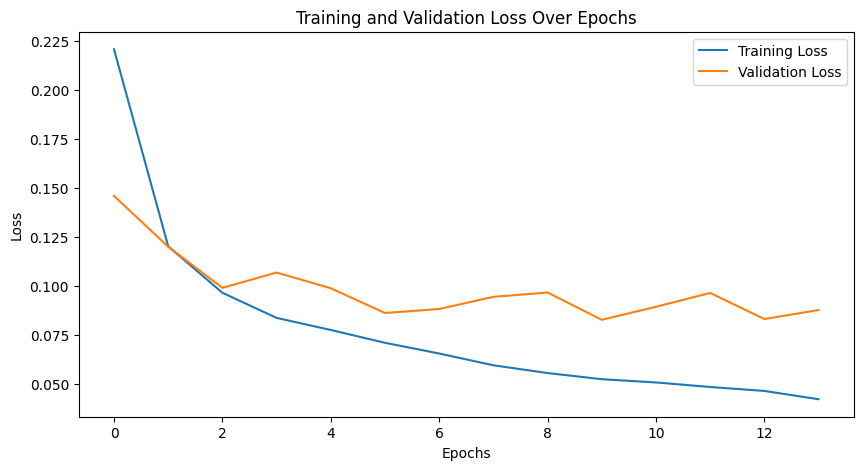

In [14]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
plot_losses(loss_training_values, loss_validation_values)

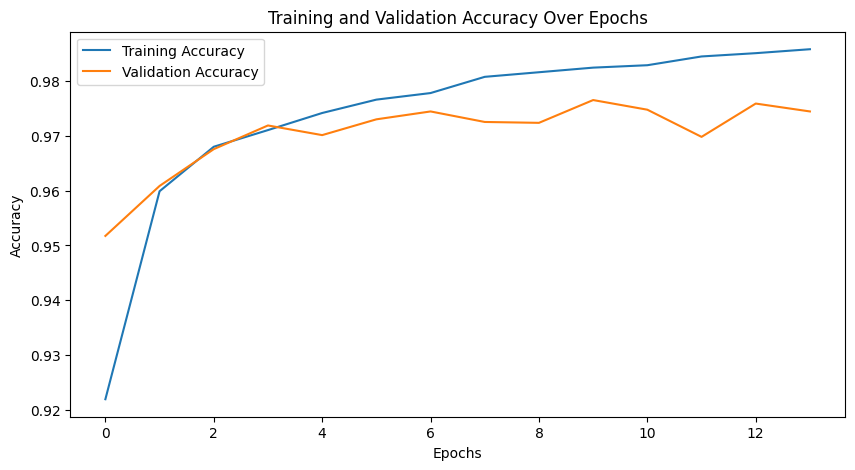

In [15]:
def plot_accuracies(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()
    
plot_accuracies(acc_training_values, acc_validation)

In [20]:
def predict_text(model, text, vocab, max_len=1000, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Set model to evaluation mode
    model.eval()
    
    # Tokenize and convert text to sequence
    sequence = [vocab.get(word, vocab["<UNK>"]) for word in text.split()]
    if len(sequence) < max_len:
        sequence.extend([vocab["<PAD>"]] * (max_len - len(sequence)))
    sequence = sequence[:max_len]
    
    # Convert to tensor
    sequence_tensor = torch.tensor([sequence], dtype=torch.long).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(sequence_tensor)
        prediction = torch.sigmoid(output.squeeze())
        probability = prediction.item()
        binary_prediction = 1 if probability >= 0.5 else 0
    
    return binary_prediction, probability



In [18]:
# Load the saved model
model = MLPModel(
                embedding_matrix=embedding_matrix,
                 hidden_dims=[256, 128,64],
                output_dim=1
                ).to(device)
model.load_state_dict(torch.load('best_mlp_model.pth'))


C:\Users\dell\AppData\Local\Temp\ipykernel_11360\3883013410.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mlp_model.pth'))


<All keys matched successfully>

In [21]:
# Example usage
new_text1 = "The meshich will be coming soon"
new_text2 = "Donald Trump has proposed a new change"
prediction, probability = predict_text(model, new_text1, vocab)
print(f"Prediction: {'Fake' if prediction == 1 else 'Real'}")
print(f"Confidence: {probability:.2%}")

prediction, probability = predict_text(model, new_text2, vocab)
print(f"Prediction: {'Fake' if prediction == 1 else 'Real'}")
print(f"Confidence: {probability:.2%}")


Prediction: Fake
Confidence: 99.21%
Prediction: Fake
Confidence: 73.34%


In [22]:
def analyze_training_bias(train_data, word_of_interest):
    # Filter articles containing the word
    contains_word = train_data[train_data['text'].str.contains(word_of_interest, case=False)]
    
    # Calculate statistics
    total_articles = len(contains_word)
    fake_articles = contains_word[contains_word['label'] == 1].shape[0]
    real_articles = contains_word[contains_word['label'] == 0].shape[0]
    
    print(f"Statistics for articles containing '{word_of_interest}':")
    print(f"Total articles: {total_articles}")
    print(f"Fake news: {fake_articles} ({fake_articles/total_articles*100:.2f}%)")
    print(f"Real news: {real_articles} ({real_articles/total_articles*100:.2f}%)")

# Usage
analyze_training_bias(train_data, "Trump")
analyze_training_bias(train_data, "president")

Statistics for articles containing 'Trump':
Total articles: 12425
Fake news: 7068 (56.89%)
Real news: 5357 (43.11%)
Statistics for articles containing 'president':
Total articles: 14852
Fake news: 6934 (46.69%)
Real news: 7918 (53.31%)


In [23]:
print(loss_training_values)
print(loss_validation_values)

[0.22061457564890155, 0.12027535537355323, 0.09659192092314667, 0.08380062874028338, 0.07765209863775935, 0.07111800880329552, 0.06566951336579381, 0.059674221728803496, 0.05571222377109602, 0.05258839293044075, 0.05092555373112551, 0.04862421676088339, 0.046604482630549636, 0.04239071517309119]
[0.1459467157873572, 0.12005162662921512, 0.09909355922896719, 0.10690604136990649, 0.09890409212854064, 0.08629459127242088, 0.08834157857986889, 0.09452239019743984, 0.09672726194578585, 0.0828391908233206, 0.08945340108083637, 0.09651441346587879, 0.08321741070391667, 0.0877931667634343]
